In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
from sklearn.ensemble import RandomForestRegressor
sns.set()

import statsmodels.api as sm
%matplotlib inline

# 設定
import warnings
warnings.filterwarnings("ignore")

In [10]:
item=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/items.csv")
item_categories=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/item_categories.csv")
sales_train=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/sales_train.csv")
shops=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/shops.csv")
test_csv=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/test.csv")
sample_submission=pd.read_csv("/Users/tasuke0630/making/DataScience/kaggle/future_sales/sample_submission.csv")

In [11]:
# 日付カラムを正しくフォーマットする
sales_train.date=sales_train.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# 確認
print(sales_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [12]:
#agg()の引数に、適用したい処理を表す文字列や呼び出し可能オブジェクトのリストを指定
monthly_sales=sales_train.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})
monthly_sales.head()

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0

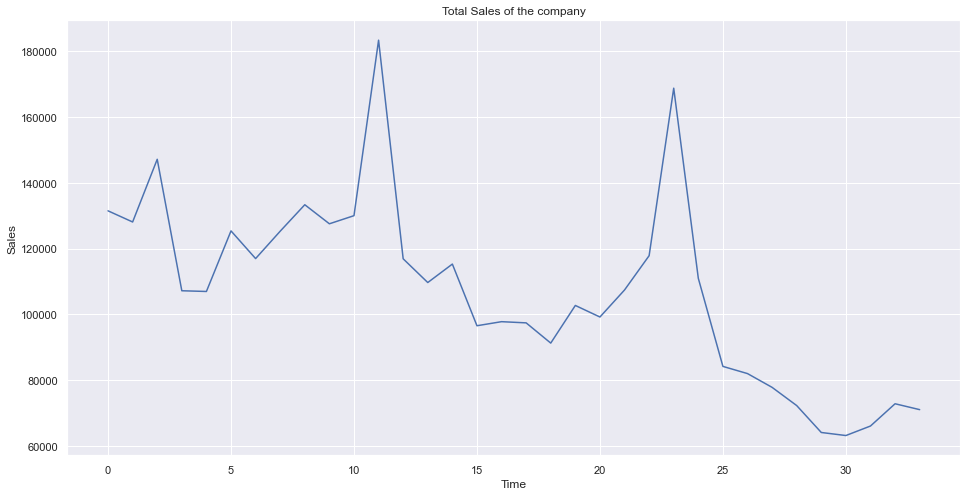

In [13]:
df=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()
df.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(df);

In [14]:
# 日付をインデックスとして時系列に追加する
df2=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()
df2.index=pd.date_range(start="2013-01",end="2015-10",freq="MS")
df2=df2.reset_index()
df2=df2.rename(columns={"index":"ds","item_cnt_day":"y"})
df2.head()

,ds,y
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [15]:
from fbprophet import Prophet
# prophetは以下の設定でpandas dfを必要とします。
# ( date column named as DS and the value column as Y)
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(df2) #fit the model with your dataframe

Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [16]:
# predict for five months in the furure and MS - month start is the frequency
future=model.make_future_dataframe(periods=5,freq="MS")  
# now lets make the forecasts
forecast=model.predict(future)
forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83193.957233,80152.376084,86366.380139
35,2015-12-01,125513.062914,122454.120266,128464.741320
36,2016-01-01,75625.688515,72369.625513,78554.087336
37,2016-02-01,40109.144414,37075.871394,43321.741834
38,2016-03-01,76664.084640,73516.392090,80167.504043


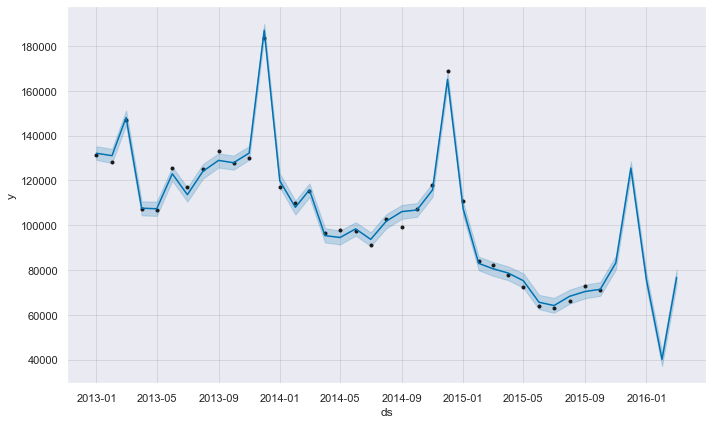

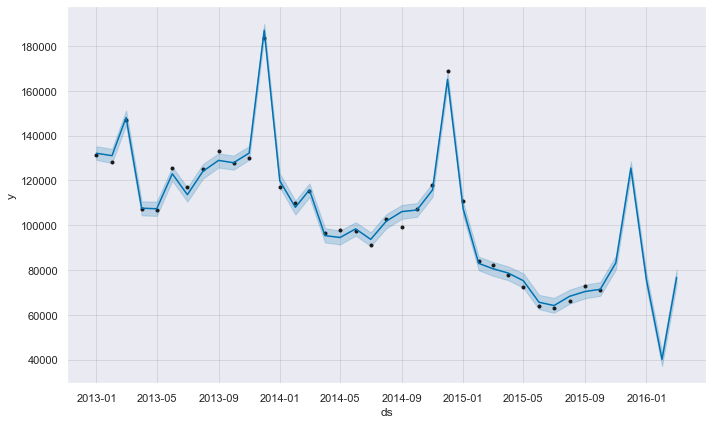

In [17]:
model.plot(forecast)

In [19]:
pred=forecast["yhat"][34]
pred

83193.95723312927

In [46]:
ratio=[0*i for i in range(34)]

for i in range(34):
    ratio[i]=pred/df[i]

In [47]:
sales_train2=sales_train.copy()
sales_train2.drop(["date","item_price"], axis=1, inplace=True)
sales_train2

,date_block_num,shop_id,item_id,item_cnt_day
0,0,59,22154,1.0
1,0,25,2552,1.0
2,0,25,2552,-1.0
3,0,25,2554,1.0
4,0,25,2555,1.0
...,...,...,...,...
2935844,33,25,7409,1.0
2935845,33,25,7460,1.0
2935846,33,25,7459,1.0
2935847,33,25,7440,1.0


In [48]:
sales_train2=sales_train2.groupby(["date_block_num","shop_id","item_id"]).sum()
sales_train2=sales_train2.pivot_table(index=["shop_id","item_id"], columns="date_block_num", values="item_cnt_day", fill_value=0)
sales_train2.reset_index(inplace=True)
sales_train2

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424119,59,22154,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424120,59,22155,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
424121,59,22162,0,0,0,0,0,0,0,0,...,0,9,4,1,1,0,0,1,0,0
424122,59,22164,0,0,0,0,0,0,0,0,...,0,2,1,2,0,0,1,0,0,0


In [49]:
x1=sales_train2.values
x2=sales_train2.keys()

#各ショップで売れたアイテムの総数
item_list=[0*i for i in range(424124)]

for i in range(424124):
    for j in range(34):
        item_list[i]+=(x1[i][j+2])*ratio[j]

In [50]:
shop_id=sales_train2.loc[:,"shop_id"]
item_id=sales_train2.loc[:,"item_id"]
df_x=pd.DataFrame(item_list)
df_shop_id=pd.DataFrame(shop_id)
df_item_id=pd.DataFrame(item_id)
df=pd.concat([df_shop_id,df_item_id,df_x],axis=1)
train=df.rename(columns={df.columns[2]:"item_cnt_month"})
train

,shop_id,item_id,item_cnt_month
0,0,30,20.134380
1,0,31,7.144457
2,0,32,10.291489
3,0,33,3.846752
4,0,35,9.725700
...,...,...,...
424119,59,22154,0.632755
424120,59,22155,0.711266
424121,59,22162,16.428950
424122,59,22164,6.445089


In [51]:
train2=[0*i for i in range(424124)]

for i in range(424124):
    train2[i]=((train["item_cnt_month"][i])/34)
    
train["item_cnt_month"]=train2
train

,shop_id,item_id,item_cnt_month
0,0,30,0.592188
1,0,31,0.210131
2,0,32,0.302691
3,0,33,0.113140
4,0,35,0.286050
...,...,...,...
424119,59,22154,0.018610
424120,59,22155,0.020920
424121,59,22162,0.483204
424122,59,22164,0.189561


In [52]:
#trainのデータ
train_x=train.drop(columns=["item_cnt_month"])
train_y=train["item_cnt_month"]

In [53]:
clf=RandomForestRegressor(n_jobs=-1, random_state=2525)
clf.fit(train_x,train_y)

RandomForestRegressor(n_jobs=-1, random_state=2525)

In [54]:
y_predict=clf.predict(test_csv.drop(columns="ID"))

In [57]:
result=np.round(y_predict)
sample_submission["item_cnt_month"]=result
sample_submission.to_csv("prediction7.csv", index=False)

In [58]:
sample_submission

,ID,item_cnt_month
0,0,0.0
1,1,1.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
214195,214195,0.0
214196,214196,0.0
214197,214197,0.0
214198,214198,0.0
